In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import time as time

In [2]:
# load hairpin data
data_path = '../../../data_toyhairpin/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}




In [3]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    
    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                    # concat, embedding, variational_normal, variational_softmax, + more
          'num_units': 196,
          'norm': 'batch',          # if removed, automatically adds bias instead
          'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
          'dropout': 0.5,           # if removed, default is no dropout
             }

    
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../../results/toyhairpin'
param_path = os.path.join(save_path, 'resbindx')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: dense_0
(?, 196)
layer17: dense_0_batch
(?, 196)
layer18: dense_0_active
(?, 196)
layer19: dense_0_dropout
(?, 196)
layer20: dens

In [5]:
# initialize session
#sess.close()
sess = utils.initialize_session()

In [ ]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=20, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

In [6]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/toyhairpin/resbindx_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/toyhairpin/resbindx_best.ckpt
  test  loss:		0.04233
  test  accuracy:	0.99338+/-0.00000
  test  auc-roc:	0.99974+/-0.00000
  test  auc-pr:		0.99903+/-0.00000


In [7]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
top_outputs = np.argsort(predictionsoutput[:,0])[::-1]

## Progression of layer output for highest predicted sequence


In [64]:
#get sequence
seq=0
X = np.expand_dims(test['inputs'][top_outputs[seq]], axis=0)

INFO:tensorflow:Restoring parameters from ../../../results/toyhairpin/resbindx_best.ckpt


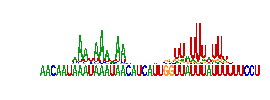

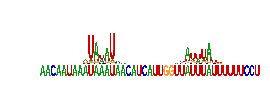

In [65]:
# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

# guided backprop
guided_saliency = saliency.guided_backprop(X, layer='output', class_index=None, params=params)

# plot and save saliency
fig = plt.figure(figsize=(10,1.5))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                np.squeeze(guided_saliency[0]).T, 
                                alphabet='rna', 
                                nt_width=400)

mf.fom_saliency(X, layer='dense_1_bias', alphabet='rna',
                nntrainer=nntrainer, sess=sess, figsize=(10,1.5))

In [66]:
def convprogression(data, L, layers, seq, order, sess, nntrainer, figsize=(10,2), exceptmean=None):
    for layer in L:
        layer = layers[layer]
        conv = nntrainer.get_activations(sess, data, layer=layer)
        conv_plot = np.squeeze(conv[seq])
        plt.figure(figsize=figsize)
        if layer == exceptmean:
            square = False
        else:
            square = True
        sb.heatmap(conv_plot[:, order], square=square, xticklabels=[])
        plt.title(layer)
        plt.xlabel('filters')
        plt.ylabel('Pooled sequence')
        plt.show()

In [67]:
#ordered by residual output
r = nntrainer.get_activations(sess, test, layer='conv1d_residual_0_resid')
r = np.squeeze(r[top_outputs[0]])
r = np.mean(r, axis=0)
order = np.argsort(np.squeeze(r))[::-1]

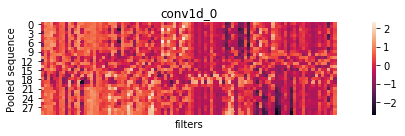

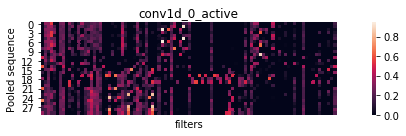

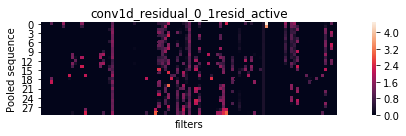

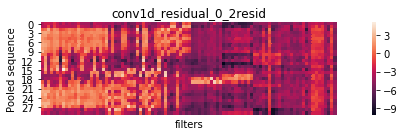

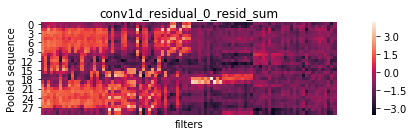

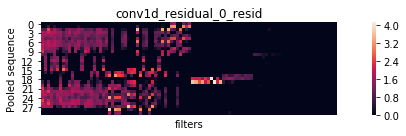

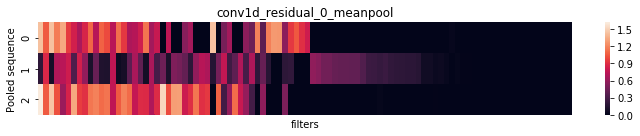

In [68]:
seq=top_outputs[0]
a = np.array([1, 3, 7, 9, 11, 12, 13])
layers = nnmodel.network.keys()

convprogression(data=test, L=a, layers=layers, exceptmean=layers[13],
                seq=seq, order=order, sess=sess, nntrainer=nntrainer)


In [14]:
#take the WT and put it into a dict for deepomics
WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
#Get output or logits activations for the WT sequence
dense = nntrainer.get_activations(sess, WT, layer='conv1d_residual_0_meanpool')

In [69]:
def fom_convsal(X, layer, alphabet, convidx, nntrainer, sess, title='notitle', figsize=(15,2)
                , fig=None, pos=None, idx=None):
    
    eps = 1e-7
    
    #choose neuron coordinates within convolution output
    i2, i3, i4 = convidx
    
    #first mutate the sequence
    X_mut = mf.mutate(X, X.shape[1], X.shape[3])

    #take all the mutations and assign them into a dict for deepomics
    mutations = {'inputs': X_mut, 'targets': np.ones((X_mut.shape[0], 1))}
    #Get the neurons score for the mutations
    mut_scores = nntrainer.get_activations(sess, mutations, layer=layer)[:, i2, i3, i4]

    #take the WT and put it into a dict for deepomics
    WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    #Get activations for the WT sequence
    WT_score = nntrainer.get_activations(sess, WT, layer=layer)[:, i2, i3, i4]

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_scores.reshape(X.shape[1],4).T
    
    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    norm_heat_mut = (heat_mut - WT_score) + eps
    norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

    if fig:
        row, col = pos
        ax = fig.add_subplot(row, col, idx)
        if title != 'notitle':
            ax.set_title(title)
        ax = visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                        norm_heat_mut,
                                        alphabet=alphabet, 
                                        nt_width=400) 

    else:
        plt.figure(figsize=figsize)
        if title != 'notitle':
            plt.title(title)
        visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                            norm_heat_mut,
                                            alphabet=alphabet, 
                                            nt_width=400) 
    

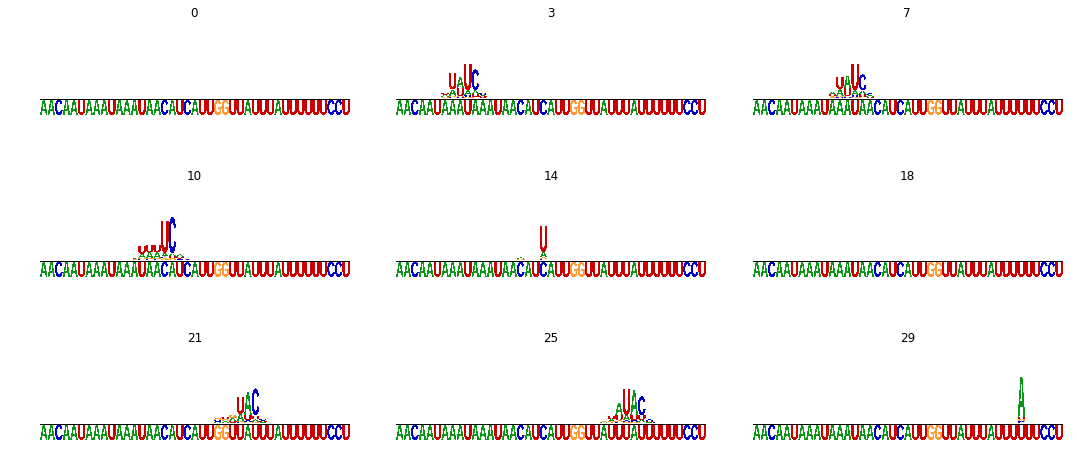

In [70]:
fig = plt.figure(figsize=(15,7))
num_plots = 9
neurons = np.linspace(0,29,num_plots).astype(int)

for ii in range(num_plots):
    neuron = neurons[ii]
    convidx = (neuron, 0, order[0])
    title = 'conv1d_residual_0_resid: ' + str(neuron)
    fom_convsal(X, 'conv1d_residual_0_resid', 'rna', convidx, nntrainer, sess, figsize=(15,2), 
                title=title, fig=fig, pos=(3,3), idx=ii+1)

array([ 0,  3,  7, 10, 14, 18, 21, 25, 29])